## 2012.1.1 - 2017.9.2 Baltimore Victim-Based Crime exploratory data analysis


In [1]:
%matplotlib inline

# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns

In [2]:
# read in kaggle 2012-2017 dataset
df = pd.read_csv("Resources/2012-2017_BPD_Victim_Based_Crime_Data.csv")
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1


## Data cleaning and preparation

Post and CrimeCode dropped. Inside/Ouside cleaned. "Time of Day" and "Day of Week" series added. No null values have been dropped (for example, there are 10,000 nulls in "Inside/Outside", or 3% of the data). 


In [3]:
# data cleaning and organization

# remove series
df.drop(columns=["CrimeCode", "Post"], inplace=True)

# consolidate Inside/Outside values, merging "O" and "I" with "Outside" and "Inside"
df["Inside/Outside"] = df["Inside/Outside"].replace({"Outside": "O", "Inside": "I"})

# convert day to datetime data type
df.CrimeDate = pd.to_datetime(df.CrimeDate)

# change midnight for to_datetime
# create temp series CrimeTimeTemp for splitting data into Time of Day
df.loc[df.CrimeTime == "24:00:00", "CrimeTime"] = "00:00:00"
df["CrimeTimeTemp"] = pd.to_datetime(df.CrimeTime, format="%H:%M:%S")

# create bins and labels for morning, afternoon, evening, late night
# -1 because it kept populating "Time of Day" with NaN for any 0 hours (12am)
bins = [-1, 6, 12, 18, 24]
labels = ["Late Night", "Morning", "Afternoon", "Evening"]

# pd.cut likes ints, so dt.hour extracts the hour for comparison with bins
# remove CrimeTimeTemp from the df
df["Time of Day"] = pd.cut(
    df.CrimeTimeTemp.dt.hour, bins=bins, labels=labels
)
df.drop(columns=["CrimeTimeTemp"], inplace=True)

# add 'Day of Week' series
df["Day of Week"] = df["CrimeDate"].dt.day_name()


In [4]:
df

,CrimeDate,CrimeTime,Location,Description,Inside/Outside,Weapon,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,Time of Day,Day of Week
0,2017-09-02,23:30:00,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,Evening,Saturday
1,2017-09-02,23:00:00,800 NEWINGTON AVE,AUTO THEFT,O,NaN,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,Evening,Saturday
2,2017-09-02,22:53:00,600 RADNOR AV,SHOOTING,O,FIREARM,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1,Evening,Saturday
3,2017-09-02,22:50:00,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,Evening,Saturday
4,2017-09-02,22:31:00,100 LIGHT ST,COMMON ASSAULT,O,HANDS,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,Evening,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276524,2012-01-01,00:00:00,1400 JOH AVE,LARCENY,I,NaN,SOUTHWESTERN,Violetville,-76.67195,39.26132,"(39.2613200000, -76.6719500000)",OTHER - IN,1,Late Night,Sunday
276525,2012-01-01,00:00:00,5500 SINCLAIR LN,LARCENY,O,NaN,NORTHEASTERN,Frankford,-76.53829,39.32493,"(39.3249300000, -76.5382900000)",OTHER - OU,1,Late Night,Sunday
276526,2012-01-01,00:00:00,400 N PATTERSON PK AV,LARCENY,O,NaN,EASTERN,CARE,-76.58497,39.29573,"(39.2957300000, -76.5849700000)",STREET,1,Late Night,Sunday
276527,2012-01-01,00:00:00,5800 LILLYAN AV,BURGLARY,I,NaN,NORTHEASTERN,Glenham-Belhar,-76.54578,39.34701,"(39.3470100000, -76.5457800000)",APT. LOCKE,1,Late Night,Sunday


## Initial visualizations

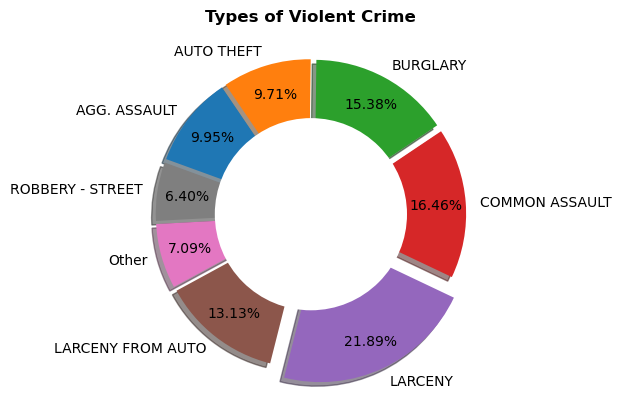

In [5]:
# pie chart of types of victim-based crime

#create temporary data frame of value counts for types of crime
desc_df = df.Description.value_counts()
desc_df = desc_df.to_frame().reset_index()
desc_df.rename(columns={'index': 'Description', 'Description': 'count'}, inplace=True)

# condense small values into a single 'Other' category
small_values = (desc_df['count'] /len(df)) < .05
desc_df.loc[small_values, 'Description'] = 'Other'
desc_df = desc_df.groupby('Description')['count'].sum()

# plot the pie chart
plt.pie(
    desc_df.values,
    labels=desc_df.index,
    explode=(0.05, 0.05, 0.05, 0.05, 0.15, 0.05, 0.05, 0.05),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Types of Violent Crime", fontweight='bold')

# add a donut hole to the pie chart
# gcf - get current figure, gca - get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

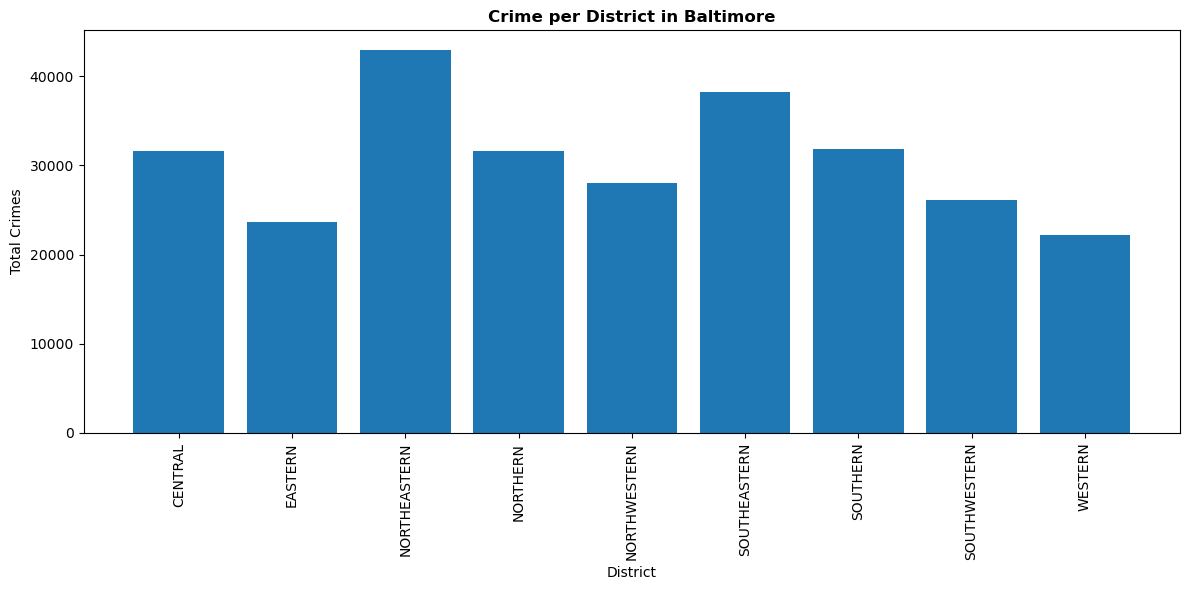

In [6]:
crime_per_District = df.groupby('District').size().reset_index(name='Total_Crimes')

plt.figure(figsize=(12, 6))
plt.bar(crime_per_District['District'], crime_per_District['Total_Crimes'])
plt.xlabel('District')
plt.ylabel('Total Crimes')
plt.title('Crime per District in Baltimore', fontweight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

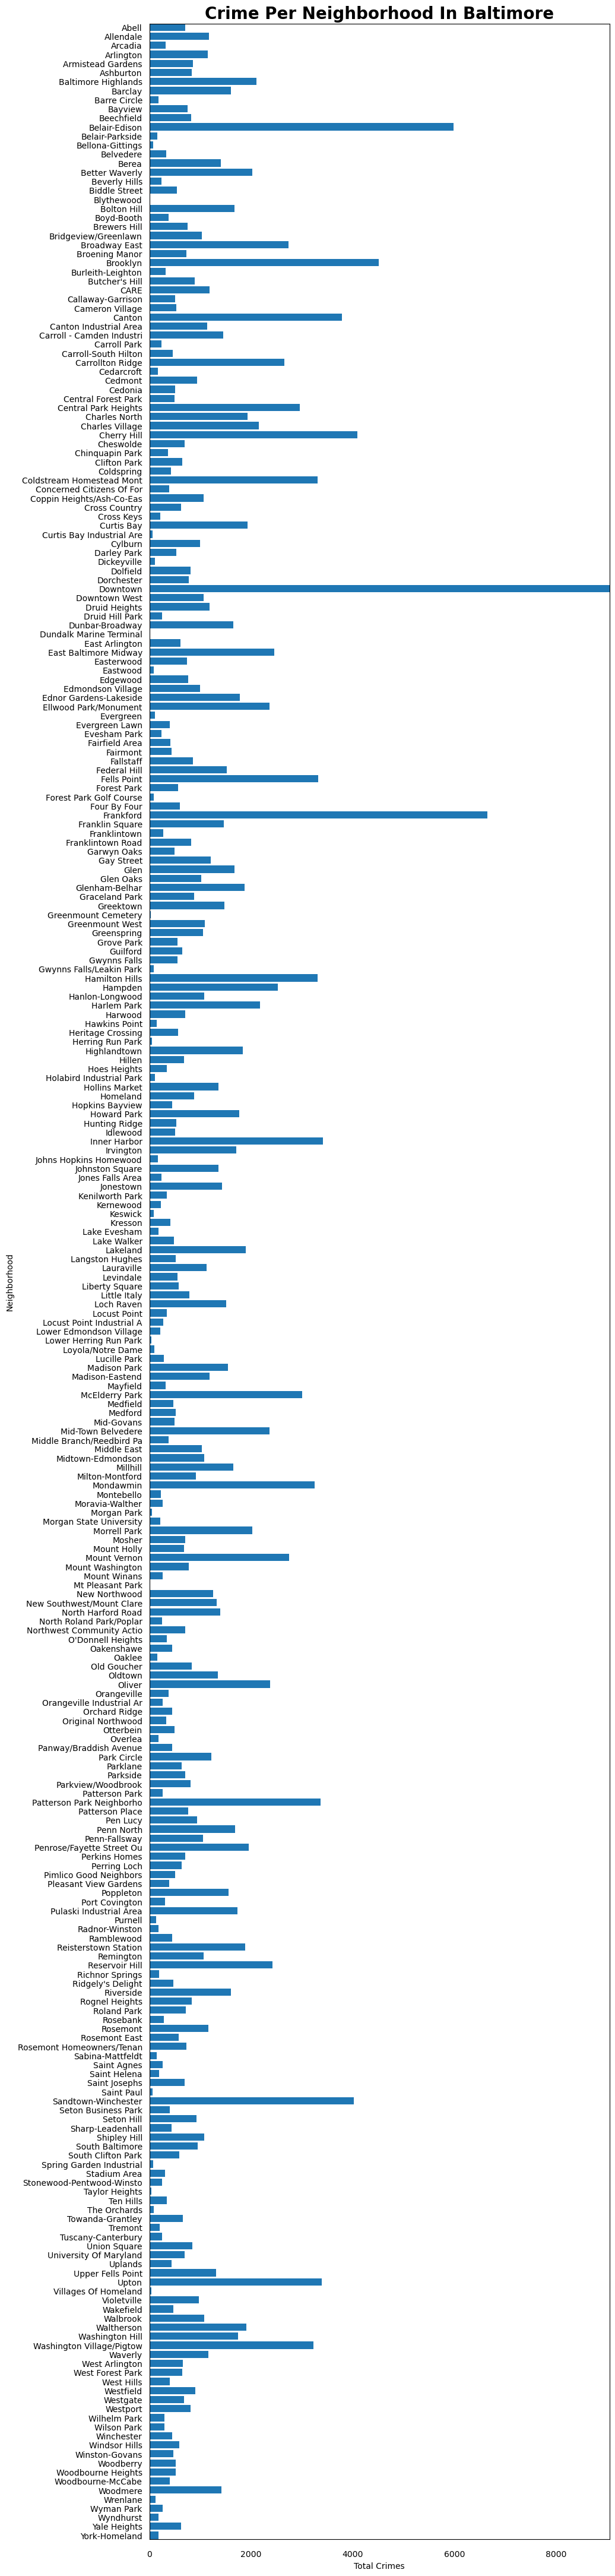

In [7]:
# calculate crime by neighborhood
crime_per_neighborhood = df.groupby('Neighborhood').size().reset_index(name='Total_Crimes')

neighborhood = crime_per_neighborhood['Neighborhood']
crime = crime_per_neighborhood['Total_Crimes']

# create plot
fig, ax = plt.subplots(figsize =(10, 55))

# horizontal plot
ax.barh(neighborhood, crime)
 
# remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 5)

plt.margins(x=0, y=0)

# invert axis
ax.invert_yaxis()

# set labels
plt.ylabel('Neighborhood')
plt.xlabel('Total Crimes')
plt.title('Crime Per Neighborhood In Baltimore', fontsize = 20, fontweight='bold')

plt.show()

In [8]:
crime_dis = df[df.CrimeDate.dt.year < 2017].groupby([df.CrimeDate.dt.year, "District"]).size().unstack()
crime_dis

District,CENTRAL,EASTERN,NORTHEASTERN,NORTHERN,NORTHWESTERN,SOUTHEASTERN,SOUTHERN,SOUTHWESTERN,WESTERN
CrimeDate,,,,,,,,,
2012,6496,4235,7728,5586,4886,6580,5796,4440,3812
2013,5656,4135,7838,5741,5324,6983,5581,4265,4035
2014,5034,3661,7513,5320,4703,6427,5213,4357,3728
2015,5317,4098,7723,5948,4778,7105,5224,4620,4007
2016,5700,4275,6882,5409,4937,6686,6001,4767,4079


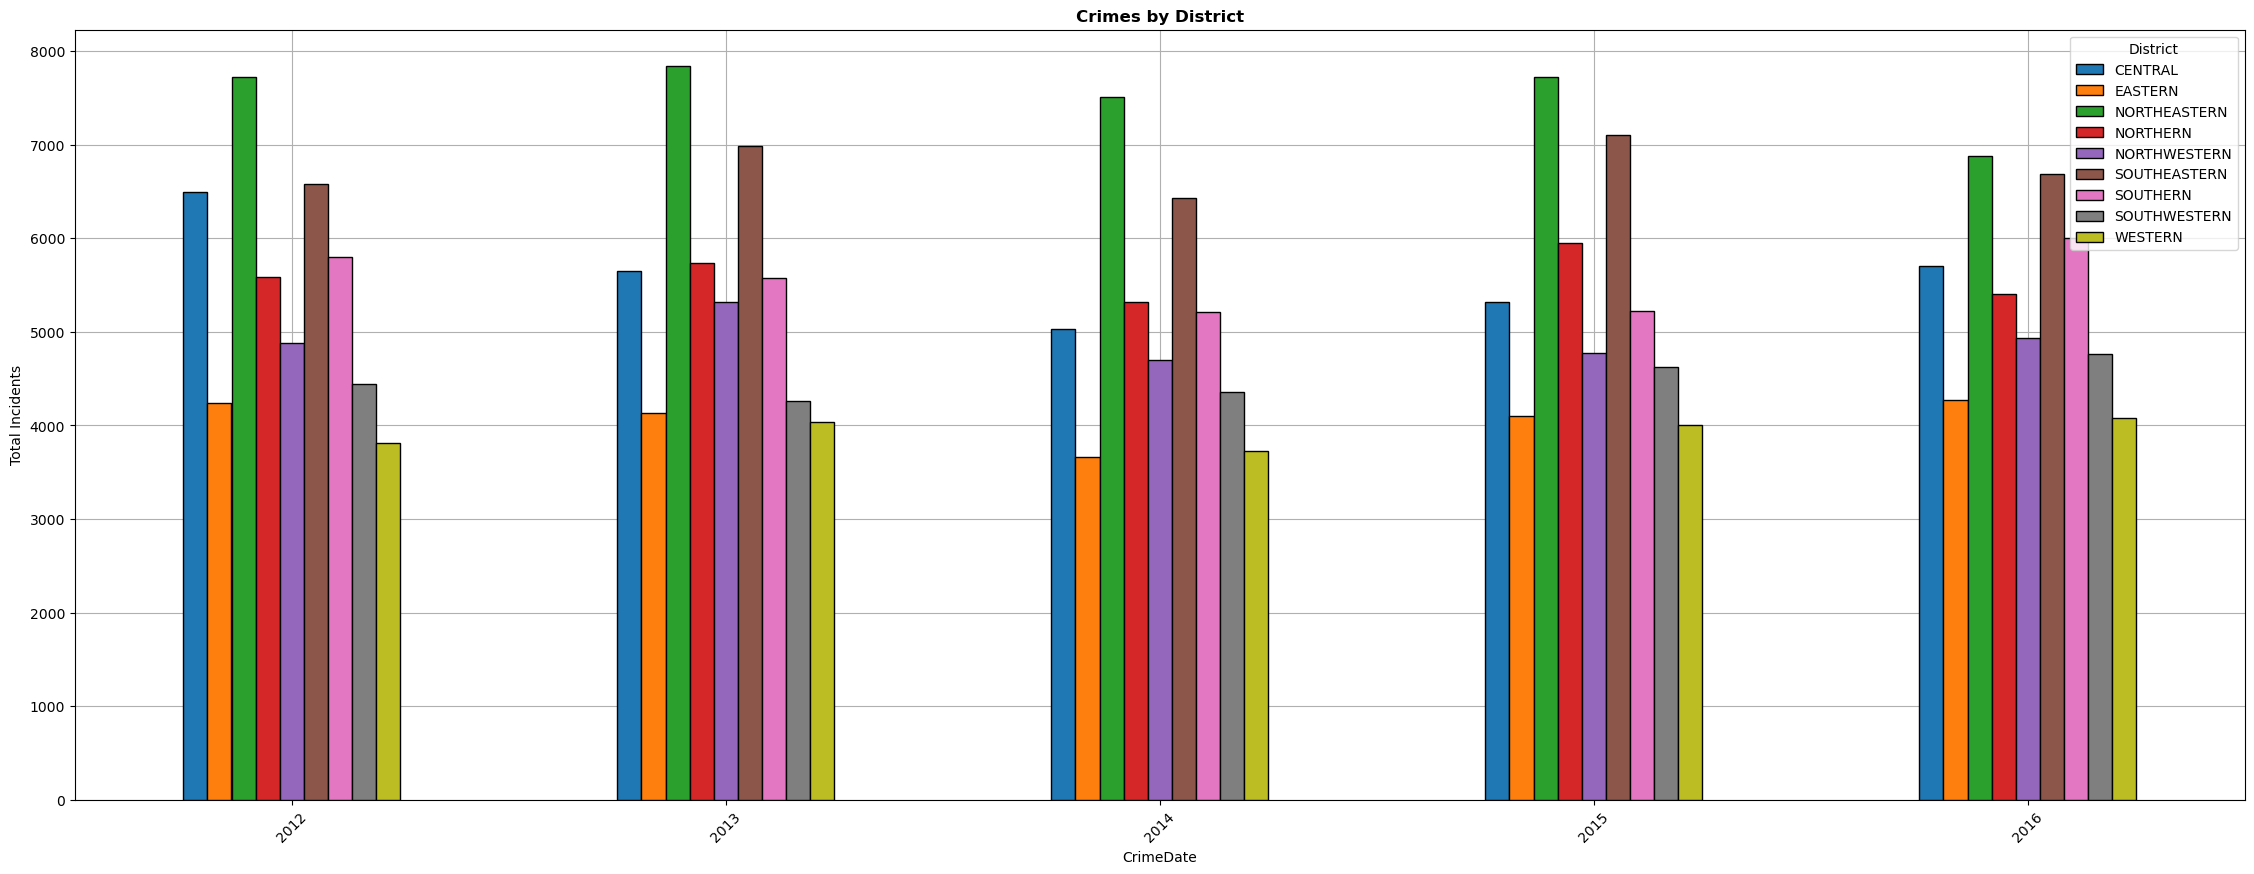

In [9]:

crime_dis.plot(kind="bar", figsize = (28, 10),edgecolor="black", zorder = 3)
plt.title("Crimes by District", fontweight='bold')
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.show()


## ANOVA

In [10]:
# ANOVA! time of day does impact the crime level in districts
m = df[df["Time of Day"] == "Morning"].groupby(df["District"]).size()
a = df[df["Time of Day"] == "Afternoon"].groupby(df["District"]).size()
e = df[df["Time of Day"] == "Evening"].groupby(df["District"]).size()
n = df[df["Time of Day"] == "Late Night"].groupby(df["District"]).size()

print(f"""{st.f_oneway(m, a, e, n)}
Time of Day has a statistical impact on the difference between the level of crime in districts""")

F_onewayResult(statistic=9.882488189277286, pvalue=9.172357793983144e-05)
Time of Day has a statistical impact on the difference between the level of crime in districts


## Question - Crime by Hour vs various indicators


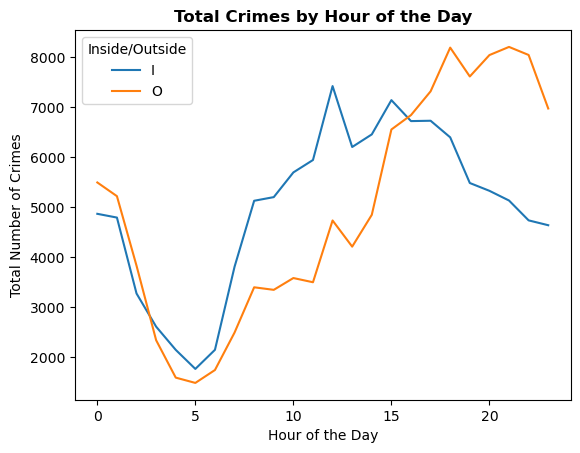

In [11]:
# temporary data frame
pre2017_df = df[df["CrimeDate"].dt.year < 2017].copy()
pre2017_df["CrimeTimeTemp"] = pd.to_datetime(pre2017_df.CrimeTime, format="%H:%M:%S")

# unstack pivots the table
_ = pre2017_df.groupby([pre2017_df["CrimeTimeTemp"].dt.hour, "Inside/Outside"]).size().unstack()

# plot the chart
# need to remove warning
_.plot(kind='line')
plt.title("Total Crimes by Hour of the Day", fontweight='bold')
plt.xlabel("Hour of the Day")
plt.ylabel("Total Number of Crimes")
plt.show()

## ANOVA

Time does not statistically impact whether victim-based crime happens indoors vs outdoors

In [12]:
# ANOVA! time of day does not impact the crime level inside vs. outside
m = df[df["Time of Day"] == "Morning"].groupby(df["Inside/Outside"]).size()
a = df[df["Time of Day"] == "Afternoon"].groupby(df["Inside/Outside"]).size()
e = df[df["Time of Day"] == "Evening"].groupby(df["Inside/Outside"]).size()
n = df[df["Time of Day"] == "Late Night"].groupby(df["Inside/Outside"]).size()

print(f"""{st.f_oneway(m, a, e, n)}
Time has no statistical impact on the difference between crime indoors and outdoors""")

F_onewayResult(statistic=2.5018363212325165, pvalue=0.19835815971583926)
Time has no statistical impact on the difference between crime indoors and outdoors


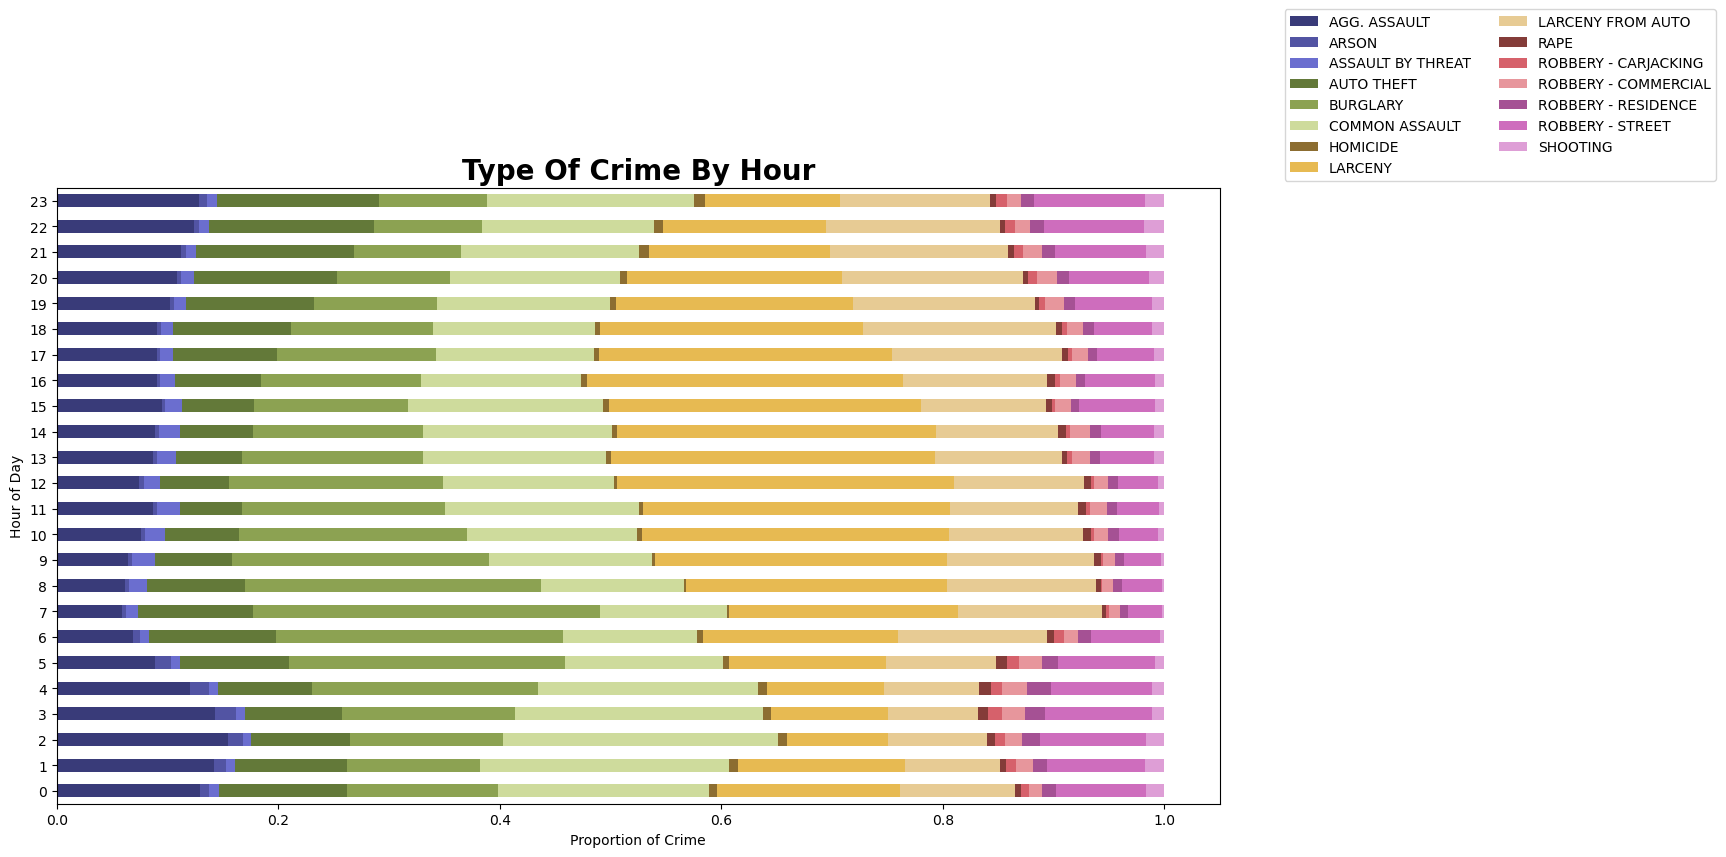

In [13]:
crime_type = df['Description']
hour_of_day = df.CrimeTime.str[:2].astype(int)

crime_type_by_hour_df = pd.DataFrame({"Type of Crime": crime_type,
                                      "Hour of Day": hour_of_day,
})

# create 100% stacked chart to show proportions of different types of crime per hour of day

# cross tabulation proportions
cross_tab_prop = pd.crosstab(index=crime_type_by_hour_df['Hour of Day'],
                             columns=crime_type_by_hour_df['Type of Crime'],
                             normalize="index")

cross_tab_prop.plot(kind='barh',
                        stacked=True,
                        colormap='tab20b',
                        figsize=(15, 8))
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower left', ncol=2)
plt.title("Type Of Crime By Hour", fontsize = 20, fontweight='bold')
plt.ylabel("Hour of Day")
plt.xlabel("Proportion of Crime")
plt.show()

In [14]:
#Convert the data into a contingency table with frequencies
contingency = pd.crosstab(crime_type_by_hour_df["Type of Crime"], crime_type_by_hour_df["Hour of Day"])
contingency

Hour of Day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Type of Crime,,,,,,,,,,,,,,,,,,,,,
AGG. ASSAULT,1644,1604,1267,812,523,336,308,422,593,631,...,1163,1483,1405,1469,1513,1548,1658,1726,1837,1733
ARSON,109,118,105,111,72,53,30,24,35,36,...,41,42,43,38,58,59,65,70,74,94
ASSAULT BY THREAT,110,93,60,46,35,32,37,77,161,214,...,249,242,213,191,178,167,172,138,132,119
AUTO THEFT,1468,1139,735,499,371,375,516,750,858,689,...,867,1007,1204,1525,1784,1754,1988,2191,2221,1977
BURGLARY,1739,1361,1129,891,886,945,1170,2253,2582,2294,...,2014,2177,2249,2321,2139,1685,1567,1494,1451,1316
COMMON ASSAULT,2430,2538,2036,1276,865,541,545,826,1256,1463,...,2241,2753,2239,2314,2448,2367,2355,2480,2309,2514
HOMICIDE,92,91,69,44,36,21,26,15,14,25,...,57,85,77,72,77,79,97,133,123,137
LARCENY,2104,1706,742,603,456,537,792,1487,2279,2612,...,3776,4398,4436,4285,3973,3254,2972,2516,2185,1639
LARCENY FROM AUTO,1332,975,732,462,375,377,608,930,1308,1314,...,1446,1755,2026,2481,2913,2491,2511,2486,2339,1829


In [15]:
#Get percentages by the Type of Crime
contingency_pct = pd.crosstab(crime_type_by_hour_df["Type of Crime"], crime_type_by_hour_df["Hour of Day"], normalize = 'index')
contingency_pct

Hour of Day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Type of Crime,,,,,,,,,,,,,,,,,,,,,
AGG. ASSAULT,0.059754,0.058300,0.046051,0.029513,0.019009,0.012212,0.011195,0.015338,0.021553,0.022935,...,0.042271,0.053902,0.051067,0.053393,0.054992,0.056264,0.060262,0.062734,0.066768,0.062988
ARSON,0.074454,0.080601,0.071721,0.075820,0.049180,0.036202,0.020492,0.016393,0.023907,0.024590,...,0.028005,0.028689,0.029372,0.025956,0.039617,0.040301,0.044399,0.047814,0.050546,0.064208
ASSAULT BY THREAT,0.031402,0.026549,0.017128,0.013132,0.009991,0.009135,0.010562,0.021981,0.045961,0.061090,...,0.071082,0.069084,0.060805,0.054525,0.050814,0.047673,0.049101,0.039395,0.037682,0.033971
AUTO THEFT,0.054699,0.042440,0.027387,0.018593,0.013824,0.013973,0.019226,0.027945,0.031970,0.025673,...,0.032305,0.037521,0.044862,0.056822,0.066473,0.065355,0.074074,0.081638,0.082756,0.073664
BURGLARY,0.040881,0.031995,0.026541,0.020946,0.020828,0.022215,0.027505,0.052964,0.060699,0.053928,...,0.047346,0.051178,0.052870,0.054563,0.050284,0.039612,0.036838,0.035122,0.034111,0.030937
COMMON ASSAULT,0.053385,0.055758,0.044730,0.028033,0.019003,0.011885,0.011973,0.018147,0.027593,0.032141,...,0.049233,0.060482,0.049189,0.050837,0.053781,0.052001,0.051738,0.054484,0.050727,0.055231
HOMICIDE,0.059012,0.058371,0.044259,0.028223,0.023092,0.013470,0.016677,0.009622,0.008980,0.016036,...,0.036562,0.054522,0.049391,0.046183,0.049391,0.050674,0.062219,0.085311,0.078897,0.087877
LARCENY,0.034761,0.028185,0.012259,0.009962,0.007534,0.008872,0.013085,0.024567,0.037652,0.043154,...,0.062384,0.072661,0.073288,0.070794,0.065639,0.053760,0.049101,0.041568,0.036099,0.027078
LARCENY FROM AUTO,0.036699,0.026863,0.020168,0.012729,0.010332,0.010387,0.016752,0.025623,0.036038,0.036203,...,0.039840,0.048354,0.055820,0.068357,0.080259,0.068632,0.069183,0.068494,0.064444,0.050393


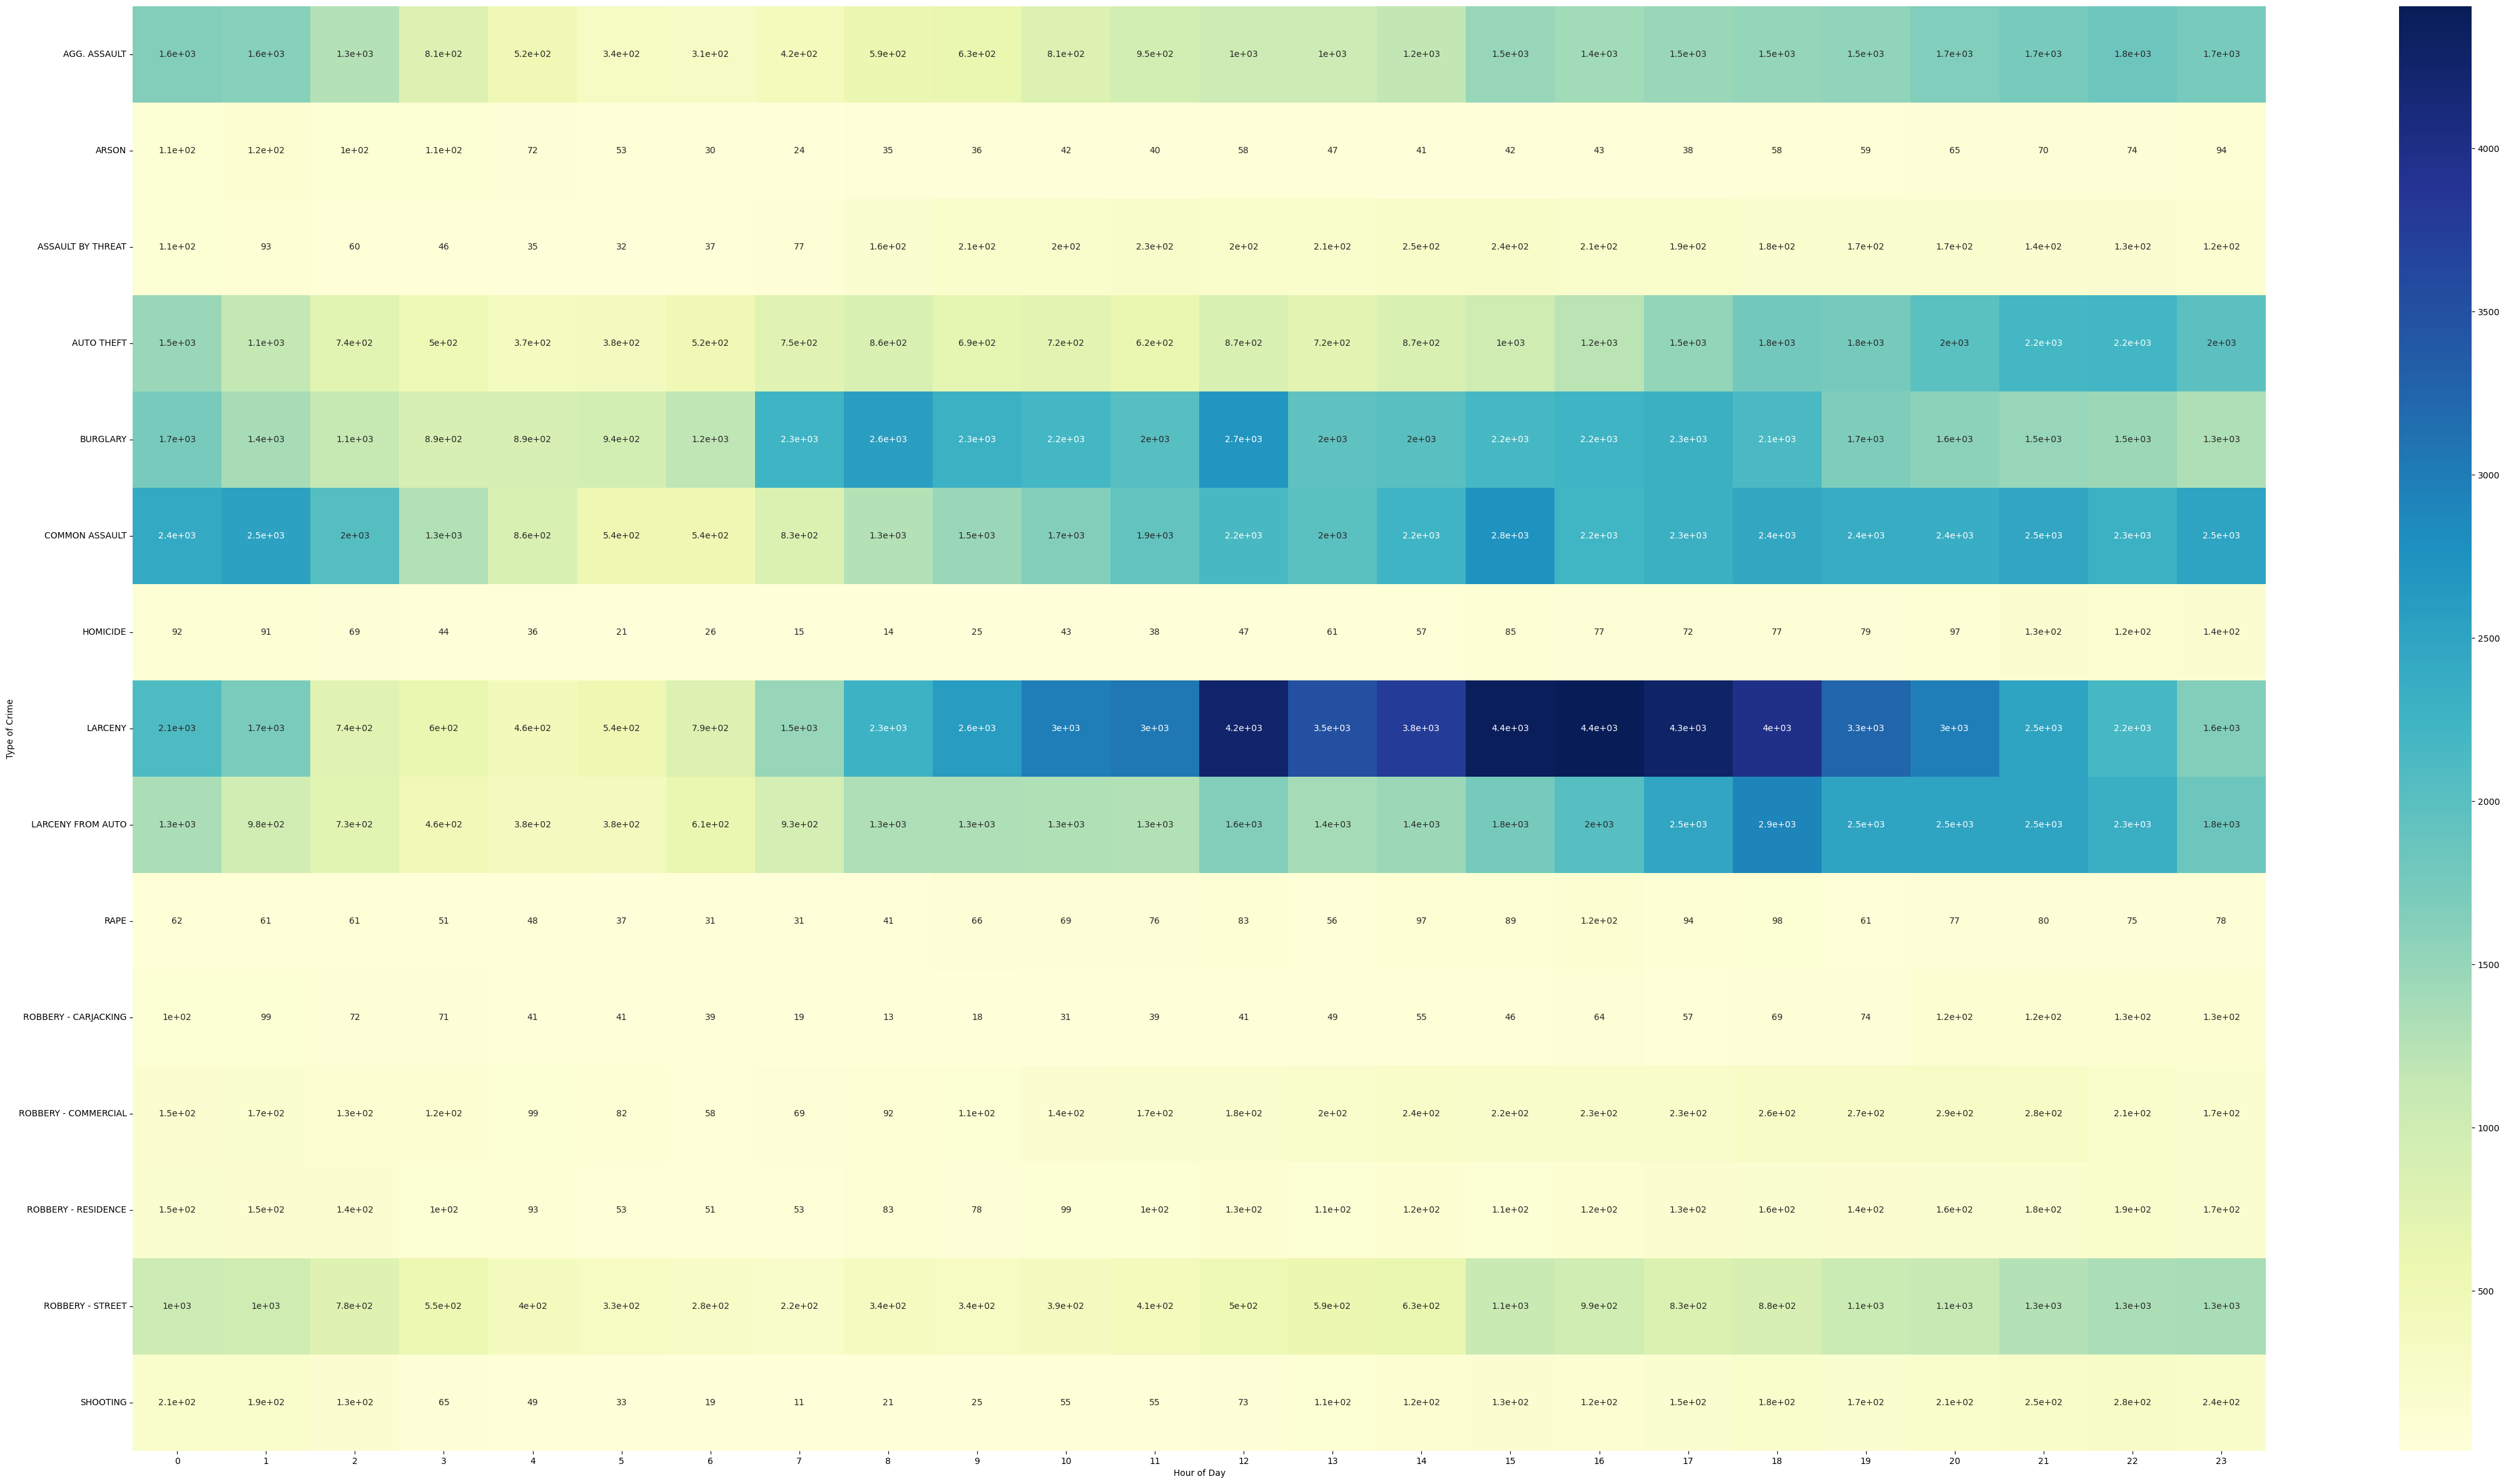

In [16]:
#Contingency tables are visually easier as heatmaps
plt.figure(figsize=(55, 30)) 
sns.heatmap(contingency, annot=True, cmap="YlGnBu")
plt.show()

In [17]:
# Chi-square test of independence. 
c, p, dof, expected = st.chi2_contingency(contingency) 
# Print the p-value
print(f"p-value =",p)

p-value = 0.0


In [18]:
# chi square
_ = pd.crosstab(crime_type_by_hour_df["Type of Crime"], crime_type_by_hour_df["Hour of Day"])
print(f"""{_}


Chi square test:

{st.chisquare(_)}

Chisquare contingency:

{st.chi2_contingency(_)}""")

Hour of Day             0     1     2     3    4    5     6     7     8   \
Type of Crime                                                              
AGG. ASSAULT          1644  1604  1267   812  523  336   308   422   593   
ARSON                  109   118   105   111   72   53    30    24    35   
ASSAULT BY THREAT      110    93    60    46   35   32    37    77   161   
AUTO THEFT            1468  1139   735   499  371  375   516   750   858   
BURGLARY              1739  1361  1129   891  886  945  1170  2253  2582   
COMMON ASSAULT        2430  2538  2036  1276  865  541   545   826  1256   
HOMICIDE                92    91    69    44   36   21    26    15    14   
LARCENY               2104  1706   742   603  456  537   792  1487  2279   
LARCENY FROM AUTO     1332   975   732   462  375  377   608   930  1308   
RAPE                    62    61    61    51   48   37    31    31    41   
ROBBERY - CARJACKING   100    99    72    71   41   41    39    19    13   
ROBBERY - CO

In [19]:
print("""The chi square statistics indicate there is no statistical link between the type of crime and hour of the week.
""")

The chi square statistics indicate there is no statistical link between the type of crime and hour of the week.



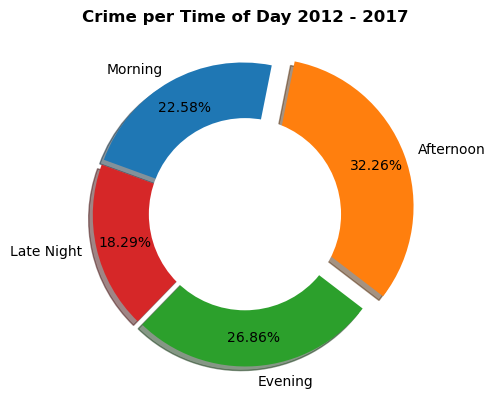

In [20]:
crime_tod = df["Time of Day"].value_counts()
crime_tod = crime_tod.reindex(["Morning", "Afternoon", "Evening", "Late Night"])

plt.pie(
    crime_tod.values,
    labels=crime_tod.index,
    explode=(0.03, 0.15, 0.03, 0.03),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Crime per Time of Day 2012 - 2017", fontweight='bold')

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

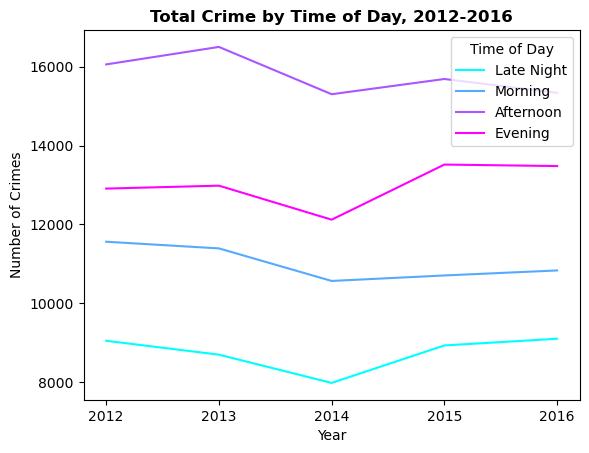

In [21]:
# temporary data frame dropping 2017 (which ends September 2nd, skewing totals)
pre2017_df = df[df.CrimeDate.dt.year < 2017]

# unstack pivots the table
x = pre2017_df.groupby([pre2017_df.CrimeDate.dt.year, "Time of Day"]).size().unstack()

# plot and format
x.plot(kind='line', cmap=plt.colormaps.get_cmap("cool"))
plt.title("Total Crime by Time of Day, 2012-2016", fontweight='bold')
plt.xticks(x.index.astype(int))
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.show()

In [22]:
time_of_day = df[df.CrimeDate.dt.year < 2017].groupby([df.CrimeDate.dt.year, "Time of Day"]).size().unstack()
time_of_day = time_of_day.reindex(columns =["Morning", "Afternoon", "Evening", "Late Night"])
print("Table of number of crimes per year, cateogrized by time of day.")
time_of_day

Table of number of crimes per year, cateogrized by time of day.


Time of Day,Morning,Afternoon,Evening,Late Night
CrimeDate,,,,
2012,11561,16056,12908,9050
2013,11392,16499,12982,8698
2014,10567,15300,12120,7982
2015,10706,15686,13517,8932
2016,10833,15335,13479,9102


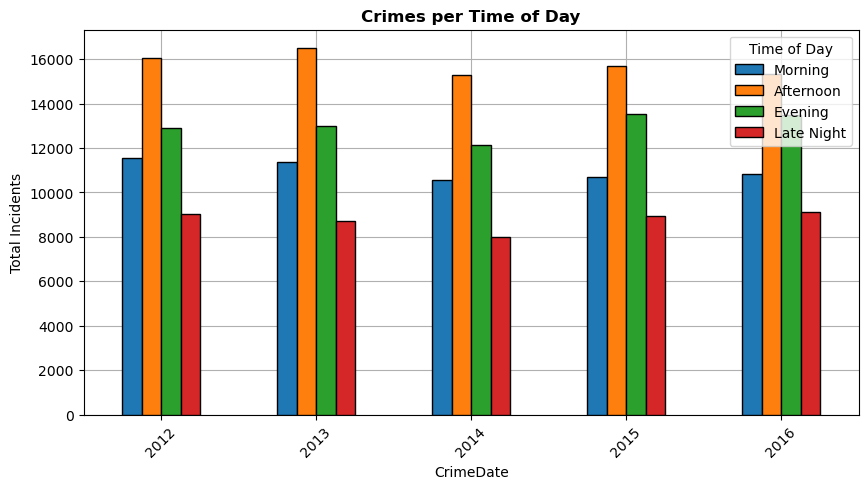

In [23]:
# Plot stacked bar graph
time_of_day.plot(kind="bar", figsize = (10, 5),edgecolor="black", zorder = 3)
plt.title("Crimes per Time of Day", fontweight='bold')
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.show()

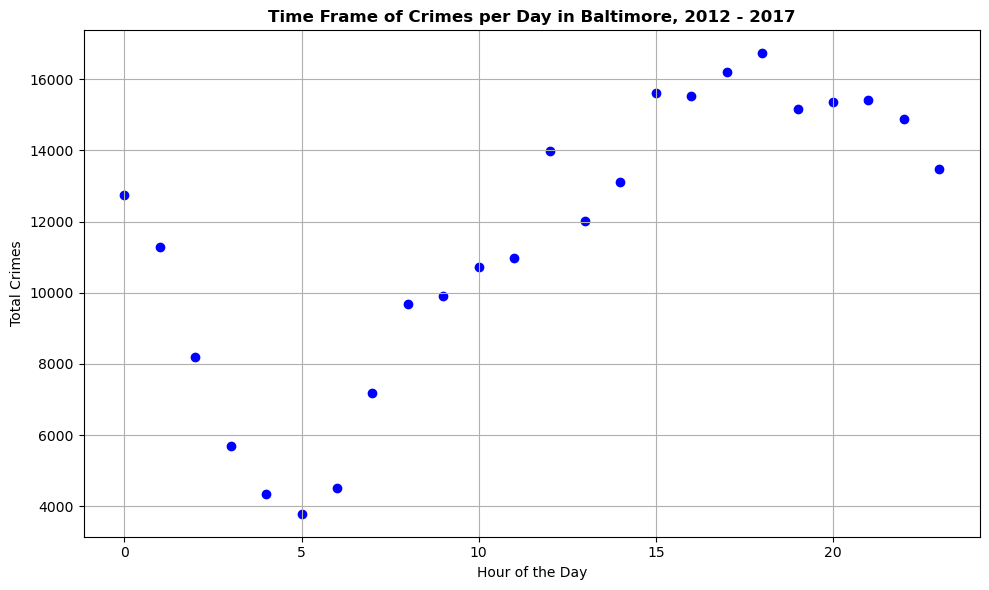

In [24]:
crime_by_hour = df.copy()
crime_by_hour["Hour"] = df.CrimeTime.str[:2].astype(int)

crime_by_hour = crime_by_hour.groupby('Hour').size().reset_index(name='Total_Crimes')

plt.figure(figsize=(10, 6))
plt.scatter(crime_by_hour['Hour'], crime_by_hour['Total_Crimes'], marker='o', color='b')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Crimes')
plt.title('Time Frame of Crimes per Day in Baltimore, 2012 - 2017', fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

## Linear Regression

The slope for Sunday is 40.587826086956525
The r-value is 0.4977664036358951
The pvalue is 0.013317812491476167
-----
The slope for Monday is 65.98130434782608
The r-value is 0.7599378235525983
The pvalue is 1.64674638973244e-05
-----
The slope for Tuesday is 68.78478260869565
The r-value is 0.7868991613438004
The pvalue is 5.09180748886111e-06
-----
The slope for Wednesday is 67.75999999999999
The r-value is 0.7783972560799419
The pvalue is 7.501013011413863e-06
-----
The slope for Thursday is 65.79434782608695
The r-value is 0.7730847128748713
The pvalue is 9.475650440040368e-06
-----
The slope for Friday is 74.30956521739131
The r-value is 0.7913580178198913
The pvalue is 4.126687464296085e-06
-----
The slope for Saturday is 48.11217391304348
The r-value is 0.581917220173801
The pvalue is 0.002854172971297055
-----
The pvalue is well below .05, signifying a statistical correlation between time of day and the number of victim-based crimes.
The rvalue is also high, at least .5, and of

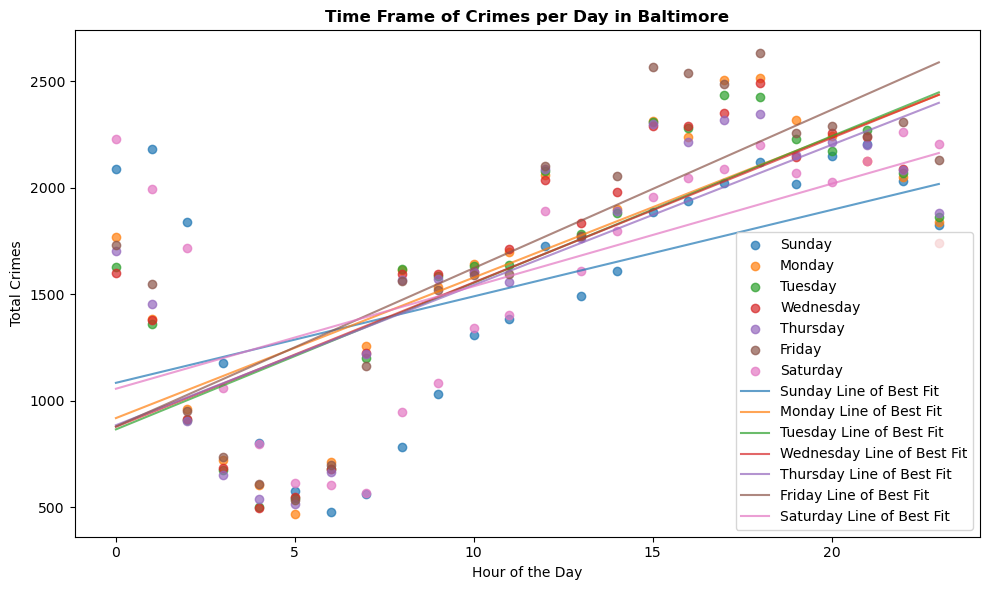

In [25]:
df['CrimeTime'] = pd.to_datetime(df['CrimeTime'])
df['Hour'] = df['CrimeTime'].dt.hour
# df['DayOfWeek'] = df['CrimeTime'].dt.day_name()

crime_by_hour = df.groupby(['Day of Week', 'Hour']).size().reset_index(name='Total_Crimes')

# List of days of the week in the desired order
days_of_week_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.figure(figsize=(10, 6))

# Iterate through each day of the week and plot the scatter points for that day
for day in days_of_week_order:
    day_data = crime_by_hour[crime_by_hour['Day of Week'] == day]
    plt.scatter(day_data['Hour'], day_data['Total_Crimes'], marker='o', label=day, alpha=0.7)

# Calculate the line of best fit using numpy's polyfit
for day in days_of_week_order:
    day_data = crime_by_hour[crime_by_hour['Day of Week'] == day]
    coef = np.polyfit(day_data['Hour'], day_data['Total_Crimes'], 1)
    plt.plot(day_data['Hour'], np.polyval(coef, day_data['Hour']), label=f'{day} Line of Best Fit', alpha=0.7)
    lr = st.linregress(day_data.Hour, day_data['Total_Crimes'])
    tmp = lr[0] * day_data.Hour + lr[1]
    #plt.plot(day_data.Hour, tmp)
    print(f"""The slope for {day} is {lr.slope}
The r-value is {lr.rvalue}
The pvalue is {lr.pvalue}
-----""")

print("""The pvalue is well below .05, signifying a statistical correlation between time of day and the number of victim-based crimes.
The rvalue is also high, at least .5, and often close to .8, meaning the scatter points fit the line relatively well.
It would be interesting to break this data up between the trough and the peak and re-run the analysis on each half of the data.
I bet the results would be stronger.""")

plt.xlabel('Hour of the Day')
plt.ylabel('Total Crimes')
plt.title('Time Frame of Crimes per Day in Baltimore', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

The linear regression line shows how the value of a scatter point on the y-axis can be predicted by the value on the x-axis. The r-value measures how closely the scatter points fit the line, on a scale of -1 to 1, with zero meaning no relationship between the scatter points and the slope of the line, and an absolute value of 1 meaning an exact fit between the line and the points. So, an r-value close to 1 or -1 means the line detects a significant relationship between the x & y axis. An r-value close to zero signifies the line has no bearing on the relationship between the x & y axis.

## ANOVA

The number of victim-based crimes occuring is impacted by time of day

In [26]:
# ANOVA
pre2017_df = df[df["CrimeDate"].dt.year < 2017]

#group populations by time of day category
m = pre2017_df[pre2017_df["Time of Day"] == "Morning"].groupby(pre2017_df["CrimeDate"].dt.year).size()
a = pre2017_df[pre2017_df["Time of Day"] == "Afternoon"].groupby(pre2017_df["CrimeDate"].dt.year).size()
e = pre2017_df[pre2017_df["Time of Day"] == "Evening"].groupby(pre2017_df["CrimeDate"].dt.year).size()
n = pre2017_df[pre2017_df["Time of Day"] == "Late Night"].groupby(pre2017_df["CrimeDate"].dt.year).size()

print(f"""{st.f_oneway(m, a, e, n)}
Note the extremely small pvalue. Crime is impacted by the time of day""")

F_onewayResult(statistic=181.68417620148915, pvalue=1.4417942015211965e-12)
Note the extremely small pvalue. Crime is impacted by the time of day


## Question - Crime by Day of Week vs various indicators


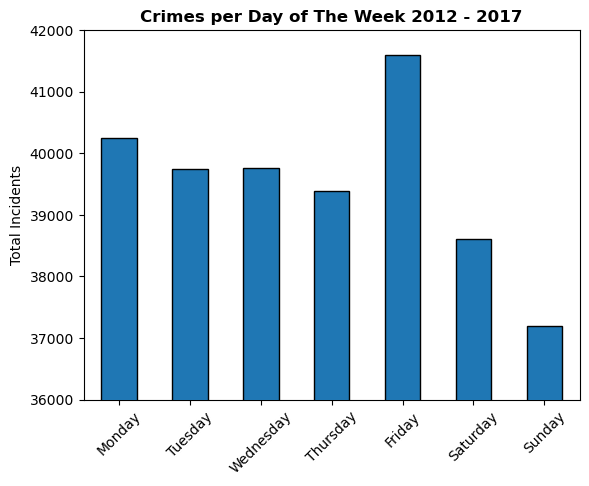

In [27]:
crime_tod = df["Day of Week"].value_counts()
crime_tod = crime_tod.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                                               'Saturday', 'Sunday'])
crime_tod.plot.bar(edgecolor="black", zorder = 3)
plt.title("Crimes per Day of The Week 2012 - 2017", fontweight='bold')
plt.ylabel("Total Incidents")
plt.xticks(rotation=45)
plt.ylim(36000, 42000)

plt.show()

Friday has the highest percentage of crimes. Sunday the lowest.


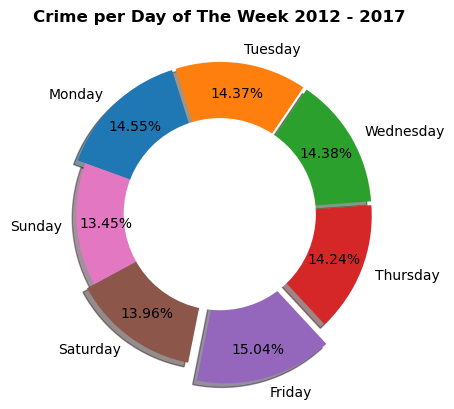

In [28]:
plt.pie(
    crime_tod.values,
    labels=crime_tod.index,
    explode=(0.03, 0.03, 0.03, 0.03, 0.15, 0.03, -0.03),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

print("Friday has the highest percentage of crimes. Sunday the lowest.")

plt.title("Crime per Day of The Week 2012 - 2017", fontweight='bold')

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

In [29]:
day_of_week = df[df.CrimeDate.dt.year < 2017].groupby([df["CrimeDate"].dt.year, "Day of Week"]).size().unstack()
day_of_week = day_of_week.reindex(columns =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                                               'Saturday', 'Sunday'])
day_of_week

Day of Week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
CrimeDate,,,,,,,
2012,7044,6929,7115,6958,7539,7149,6841
2013,7128,7160,7162,7119,7502,6921,6579
2014,6822,6465,6619,6481,6955,6460,6167
2015,7318,7234,6908,7036,7188,6715,6442
2016,7065,7131,7043,6925,7349,6644,6592


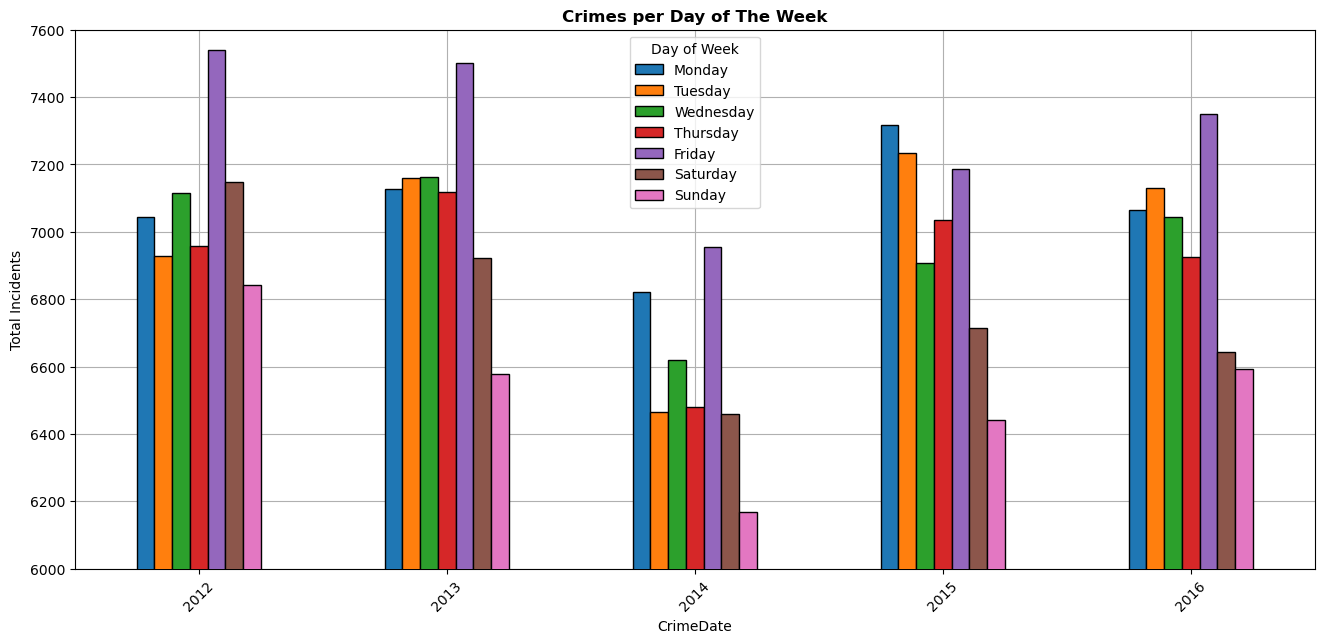

In [30]:

day_of_week.plot(kind="bar", figsize = (16, 7),edgecolor="black", zorder = 3)
plt.title("Crimes per Day of The Week", fontweight='bold')
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.ylim(6000, 7600)

plt.show()

## Chi-Square

In [31]:
# chi square
_ = pd.crosstab(pre2017_df["Time of Day"], pre2017_df["Day of Week"])
print(f"""{_}


Chi square test:

{st.chisquare(_)}

Chisquare contingency:

{st.chi2_contingency(_)}

The chi square statistics indicate there is a strong statistical link between the time of day and day of the week.
""")

Day of Week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
Time of Day                                                                
Late Night     5842    5768      7832    8039      5501     5383       5399
Morning        8433    8605      6339    5973      8450     8636       8623
Afternoon     12393   11708     10356    9707     11405    11599      11708
Evening        9865    9296      9362    8902      9163     9301       9117


Chi square test:

Power_divergenceResult(statistic=array([2461.78575534, 2026.81931764, 1097.80102688,  949.24039729,
       2063.53078015, 2264.49173802, 2309.97569375]), pvalue=array([0.00000000e+000, 0.00000000e+000, 1.09177424e-237, 1.84565997e-205,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

Chisquare contingency:

Chi2ContingencyResult(statistic=2679.7751310903027, pvalue=0.0, dof=18, expected_freq=array([[ 6587.54542346,  6379.0981974 ,  6110.78550504,  5882.14269999,
         6224.38563688,  6296.51270472,  6283

## Question - Crime by Year


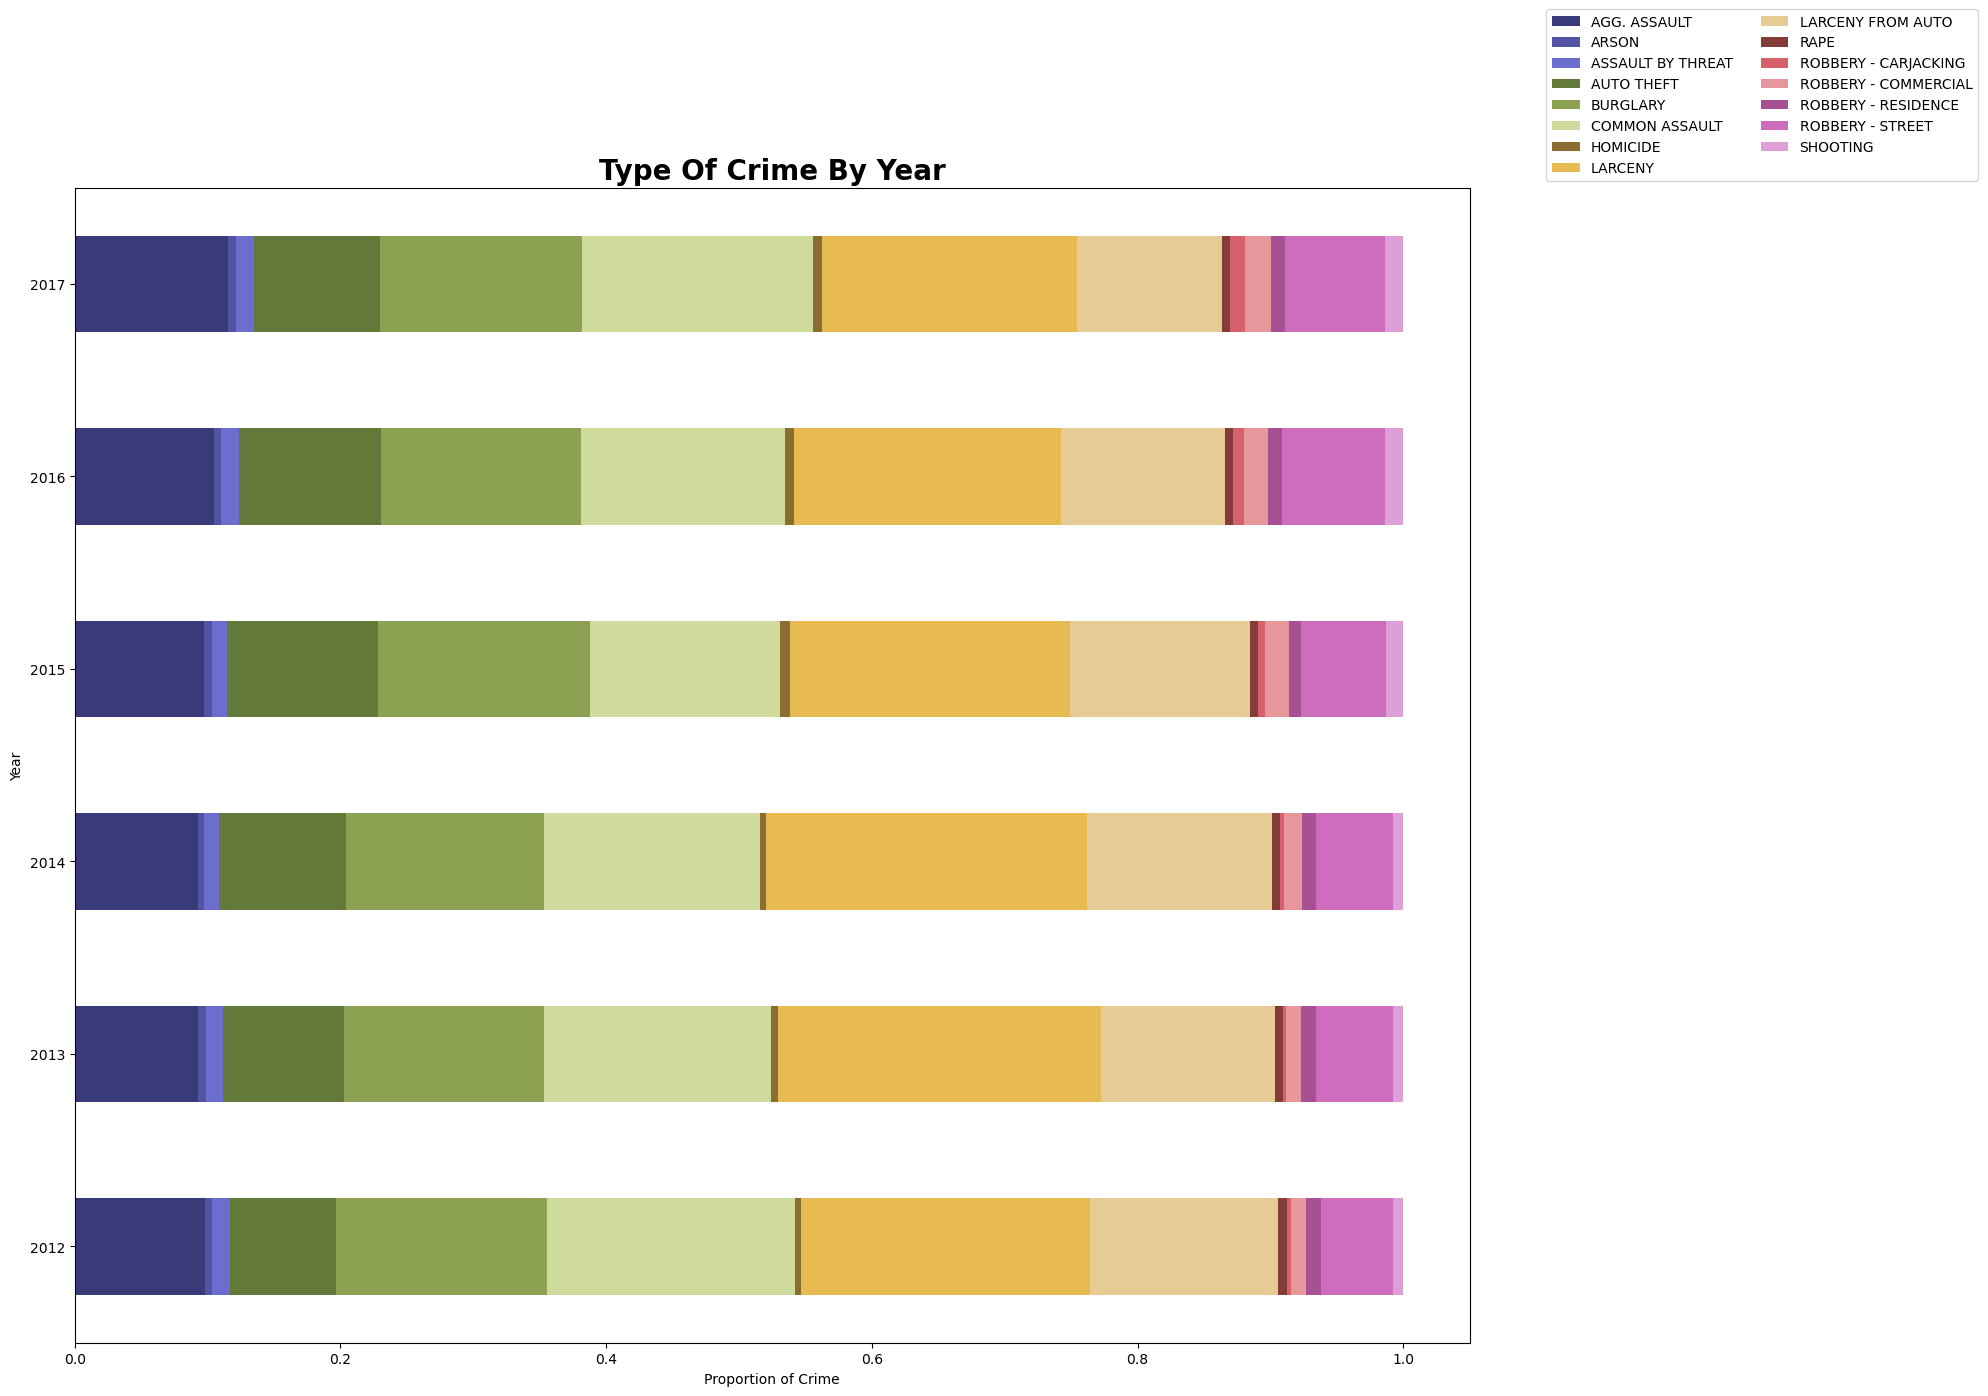

In [32]:
# get crime type data by year
df['Year'] = df["CrimeDate"].dt.year
year = df['Year']
# create dataframe
crime_type_by_year_df = pd.DataFrame({"Type of Crime": crime_type,
                                      "Year": year,
})

# cross tabulation proportions for crime by year
cross_tab_prop_year = pd.crosstab(index=crime_type_by_year_df['Year'],
                             columns=crime_type_by_year_df['Type of Crime'],
                             normalize="index")
cross_tab_prop_year
# cross tabulation counts for crime by year
cross_tab_year = pd.crosstab(index=crime_type_by_year_df['Year'],
                        columns=crime_type_by_year_df['Type of Crime'])

# create stacked horizontal chart of crime type by year
cross_tab_prop_year.plot(kind='barh',
                        stacked=True,
                        colormap='tab20b',
                        figsize=(18, 15))
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower left', ncol=2)
plt.title("Type Of Crime By Year", fontsize = 20, fontweight='bold')
plt.ylabel("Year")
plt.xlabel("Proportion of Crime")
plt.show()

## Outlier - Aftermath of the Death of Freddie Gray

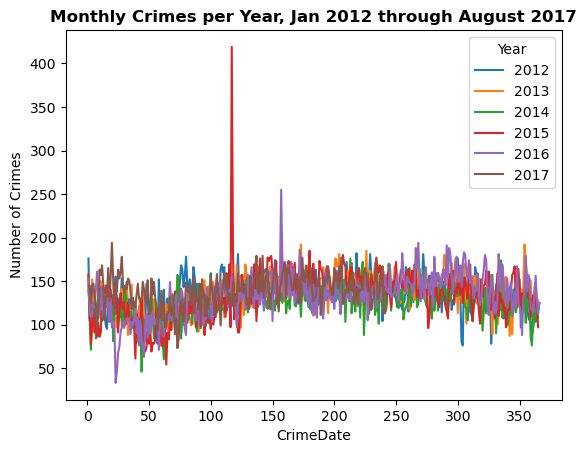

The giant spike in 2015 is the protests following the death of Freddie Gray.

Day 157 of 2016 is 5 June 2016, according to the internet.
But further research is needed to find out what happened around that day.


In [33]:
# huge outlier - Freddie Gray
import calendar

year_df = df.copy()
year_df["Year"] = year_df.CrimeDate.dt.year
year_df["Month"] = year_df.CrimeDate.dt.month
year_df["Day"] = year_df.CrimeDate.dt.year
year_df = year_df[year_df.CrimeDate < "2017-09-01"]

_ = year_df.groupby(year_df.CrimeDate.dt.dayofyear)["Year"].value_counts().unstack()
_.plot(kind='line')

# Format the plot
plt.ylabel("Number of Crimes")
plt.title("Monthly Crimes per Year, Jan 2012 through August 2017", fontweight='bold')
plt.show()

print(f"""The giant spike in 2015 is the protests following the death of Freddie Gray.

Day {_[2016].idxmax()} of 2016 is 5 June 2016, according to the internet.
But further research is needed to find out what happened around that day.""")

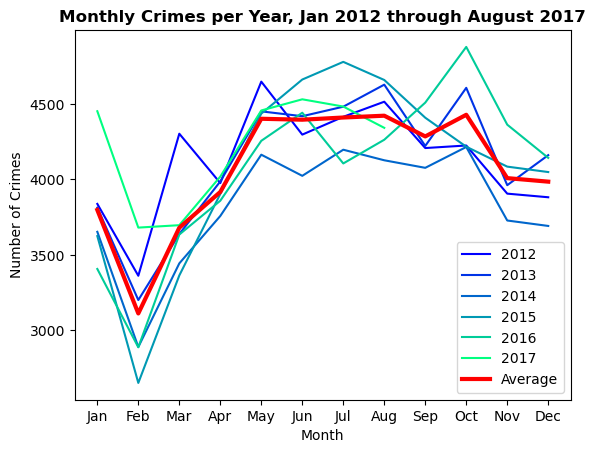

In [34]:
import calendar

year_df = df.copy()
year_df["Year"] = year_df.CrimeDate.dt.year
year_df["Month"] = year_df.CrimeDate.dt.month
year_df = year_df[year_df.CrimeDate < "2017-09-01"]

_ = year_df.groupby("Month")["Year"].value_counts().unstack()
_.plot(kind='line', cmap=plt.colormaps.get_cmap('winter'))

avg = year_df.groupby("Month")["Year"].value_counts().unstack().mean(axis=1)
plt.plot(range(1, 13), avg, color='red', linewidth=3, label='Average')

# Format the plot
plt.xticks(range(1, 13), labels=calendar.month_abbr[1:])
plt.ylabel("Number of Crimes")
plt.title("Monthly Crimes per Year, Jan 2012 through August 2017", fontweight='bold')
plt.legend()
plt.show()